# Uplift modeling `metrics`



In [1]:
import sys

# install uplift library scikit-uplift and other libraries
!{sys.executable} -m pip install scikit-uplift dill catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 689.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.0 MB/s eta 0:00:00


# Load data

Мы собираемся использовать «набор данных Ленты» из хакатона BigTarget, организованного летом 2020 года Лентой и Microsoft.

Лента — российский продуктовый ритейлер.

### Data description


####   Major columns:

- `group` - treatment / control flag
- `response_att` - binary target
- `CardHolder` - customer id
- `gender` - customer gender
- `age` - customer age

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip "/content/drive/MyDrive/Преподавание/Машинное обучение/БАК/Часть 2/uplift/archive_Lenta.zip" -d "/content/drive/MyDrive/Преподавание/Машинное обучение/БАК/Часть 2/uplift/"

In [3]:
path = "/content/drive/MyDrive/Study/7/Машинное обучение/ЛР3/pdf (1).csv"

In [4]:
import pandas as pd

data = pd.read_csv(path)

In [5]:
data.head()

,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,16095858,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,15906620,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,16495466,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,16570217,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,16346871,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495


In [6]:
data

,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,16095858,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,15906620,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,16495466,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,16570217,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,16346871,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687024,15705403,35.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,0.0,...,550.09,669.33,111.87,0.00,330.96,1173.84,119.99,2.6458,0.3646,0.3282
687025,16586008,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,28.01,0.0000,0.0000,0.0000
687026,15693616,36.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.00,0.00,0.00,0.00,0.00,449.01,0.00,0.0000,NaN,NaN
687027,15915514,37.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.00,46.72,0.00,0.00,0.00,0.00,0.00,0.0000,NaN,NaN


from matplotlib import pyplot as plt
data['CardHolder'].plot(kind='hist', bins=20, title='CardHolder')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['cheque_count_12m_g20'].plot(kind='hist', bins=20, title='cheque_count_12m_g20')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['cheque_count_12m_g21'].plot(kind='hist', bins=20, title='cheque_count_12m_g21')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('group').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='CardHolder', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='age', y='cheque_count_12m_g20', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='cheque_count_12m_g20', y='cheque_count_12m_g21', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='cheque_count_12m_g21', y='cheque_count_12m_g25', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['CardHolder'].plot(kind='line', figsize=(8, 4), title='CardHolder')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['cheque_count_12m_g20'].plot(kind='line', figsize=(8, 4), title='cheque_count_12m_g20')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['cheque_count_12m_g21'].plot(kind='line', figsize=(8, 4), title='cheque_count_12m_g21')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['group'].value_counts()
    for x_label, grp in data.groupby('gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gender')
_ = plt.ylabel('group')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='CardHolder', y='gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='CardHolder', y='group', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='age', y='gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='age', y='group', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [7]:
print(f"Dataset features shape: {data.shape}")


Dataset features shape: (687029, 196)


In [8]:
data.columns.values.tolist ()

['CardHolder',
 'age',
 'cheque_count_12m_g20',
 'cheque_count_12m_g21',
 'cheque_count_12m_g25',
 'cheque_count_12m_g32',
 'cheque_count_12m_g33',
 'cheque_count_12m_g38',
 'cheque_count_12m_g39',
 'cheque_count_12m_g41',
 'cheque_count_12m_g42',
 'cheque_count_12m_g45',
 'cheque_count_12m_g46',
 'cheque_count_12m_g48',
 'cheque_count_12m_g52',
 'cheque_count_12m_g56',
 'cheque_count_12m_g57',
 'cheque_count_12m_g58',
 'cheque_count_12m_g79',
 'cheque_count_3m_g20',
 'cheque_count_3m_g21',
 'cheque_count_3m_g25',
 'cheque_count_3m_g42',
 'cheque_count_3m_g45',
 'cheque_count_3m_g52',
 'cheque_count_3m_g56',
 'cheque_count_3m_g57',
 'cheque_count_3m_g79',
 'cheque_count_6m_g20',
 'cheque_count_6m_g21',
 'cheque_count_6m_g25',
 'cheque_count_6m_g32',
 'cheque_count_6m_g33',
 'cheque_count_6m_g38',
 'cheque_count_6m_g39',
 'cheque_count_6m_g40',
 'cheque_count_6m_g41',
 'cheque_count_6m_g42',
 'cheque_count_6m_g45',
 'cheque_count_6m_g46',
 'cheque_count_6m_g48',
 'cheque_count_6m_g52',


Описание датасета можно найти по ссылке https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html

In [9]:
data[['age', 'children', 'gender', 'group', 'response_att', 'response_viber', 'response_sms']]

,age,children,gender,group,response_att,response_viber,response_sms
0,47.0,0.0,Ж,test,0,0.071429,0.923077
1,57.0,0.0,Ж,test,0,0.000000,1.000000
2,38.0,3.0,М,control,0,0.250000,1.000000
3,65.0,0.0,Ж,test,0,0.000000,0.909091
4,61.0,2.0,Ж,test,0,0.100000,1.000000
...,...,...,...,...,...,...,...
687024,35.0,3.0,Ж,control,0,0.166667,0.000000
687025,33.0,0.0,М,test,0,0.000000,1.000000
687026,36.0,0.0,М,control,0,0.000000,1.000000
687027,37.0,0.0,М,control,0,0.000000,1.000000


from matplotlib import pyplot as plt
_df_0['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['children'].plot(kind='hist', bins=20, title='children')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['response_att'].plot(kind='hist', bins=20, title='response_att')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['response_viber'].plot(kind='hist', bins=20, title='response_viber')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('group').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='age', y='children', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='children', y='response_att', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='response_att', y='response_viber', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='response_viber', y='response_sms', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['children'].plot(kind='line', figsize=(8, 4), title='children')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['response_att'].plot(kind='line', figsize=(8, 4), title='response_att')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['response_viber'].plot(kind='line', figsize=(8, 4), title='response_viber')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['group'].value_counts()
    for x_label, grp in _df_14.groupby('gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gender')
_ = plt.ylabel('group')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='age', y='gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='age', y='group', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='children', y='gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='children', y='group', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

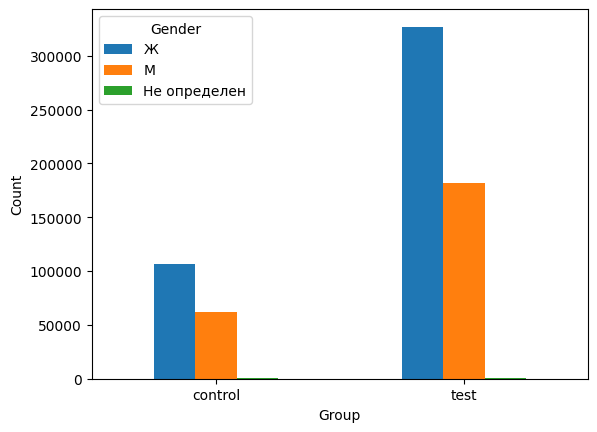

In [10]:
from matplotlib import pyplot as plt

df_count = data.groupby(['group','gender']).size().unstack(fill_value=0)

# Нарисуем столбчатую диаграмму
ax = df_count.plot.bar(rot=0)
ax.set_xlabel('Group')
ax.set_ylabel('Count')
ax.legend(title='Gender')

plt.show()

#  EDA

In [11]:
data.head().append(data.tail())

<ipython-input-11-afca6e99889a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data.head().append(data.tail())


,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,16095858,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,15906620,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,16495466,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,16570217,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,16346871,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495
687024,15705403,35.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,0.0,...,550.09,669.33,111.87,0.00,330.96,1173.84,119.99,2.6458,0.3646,0.3282
687025,16586008,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,28.01,0.0000,0.0000,0.0000
687026,15693616,36.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.00,0.00,0.00,0.00,0.00,449.01,0.00,0.0000,NaN,NaN
687027,15915514,37.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.00,46.72,0.00,0.00,0.00,0.00,0.00,0.0000,NaN,NaN
687028,15817354,40.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,...,290.01,0.00,0.00,0.00,228.47,752.32,596.86,0.0000,0.0000,0.0000


###  target share for `treatment / control`

In [12]:
pd.crosstab(data['group'], data['response_att'], normalize='index')

response_att,0,1
group,,
control,0.897421,0.102579
test,0.889874,0.110126


In [13]:
treatment = data['group']
target = data['response_att']
data_X=data.drop(['group','response_att'] , axis=1)

In [14]:
data_X.columns.values.tolist ()

['CardHolder',
 'age',
 'cheque_count_12m_g20',
 'cheque_count_12m_g21',
 'cheque_count_12m_g25',
 'cheque_count_12m_g32',
 'cheque_count_12m_g33',
 'cheque_count_12m_g38',
 'cheque_count_12m_g39',
 'cheque_count_12m_g41',
 'cheque_count_12m_g42',
 'cheque_count_12m_g45',
 'cheque_count_12m_g46',
 'cheque_count_12m_g48',
 'cheque_count_12m_g52',
 'cheque_count_12m_g56',
 'cheque_count_12m_g57',
 'cheque_count_12m_g58',
 'cheque_count_12m_g79',
 'cheque_count_3m_g20',
 'cheque_count_3m_g21',
 'cheque_count_3m_g25',
 'cheque_count_3m_g42',
 'cheque_count_3m_g45',
 'cheque_count_3m_g52',
 'cheque_count_3m_g56',
 'cheque_count_3m_g57',
 'cheque_count_3m_g79',
 'cheque_count_6m_g20',
 'cheque_count_6m_g21',
 'cheque_count_6m_g25',
 'cheque_count_6m_g32',
 'cheque_count_6m_g33',
 'cheque_count_6m_g38',
 'cheque_count_6m_g39',
 'cheque_count_6m_g40',
 'cheque_count_6m_g41',
 'cheque_count_6m_g42',
 'cheque_count_6m_g45',
 'cheque_count_6m_g46',
 'cheque_count_6m_g48',
 'cheque_count_6m_g52',


In [15]:
# make treatment binary
treat_dict = {
    'test': 1,
    'control': 0
}

treatment = treatment.map(treat_dict)

In [16]:
# fill NaNs in the categorical feature `gender`
# for CatBoostClassifier
data_X['gender'] = data_X['gender'].fillna(value='Не определен')

print(data_X['gender'].value_counts(dropna=False))

Ж               433448
М               243910
Не определен      9671
Name: gender, dtype: int64


###  train test split

- stratify by two columns: treatment and target.

`Intuition:` In a binary classification problem definition we stratify train set by splitting target `0/1` column. In uplift modeling we have two columns instead of one.

In [17]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([treatment, target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    data_X,
    treatment,
    target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (480920, 194)
Validation shape: (206109, 194)


#  Class Transformation uplift model

`Class transformation` method is described <a href="https://www.uplift-modeling.com/en/latest/user_guide/models/revert_label.html"> here</a>  

Class transormation method `may` be used in case of treatment unbalanced data. In this case one will get not an uplift score but some *ranking* score still useful for ranking objects.

In [18]:
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

estimator = CatBoostClassifier(verbose=100,
                               cat_features=['gender'],
                               random_state=42,
                               thread_count=1)

ct_model = ClassTransformation(estimator=estimator)

In [19]:
ct_model.fit(
    X=X_train,
    y=y_train,
    treatment=trmnt_train
)

Learning rate set to 0.143939
0:	learn: 0.6684646	total: 1.14s	remaining: 19m 1s
100:	learn: 0.5951564	total: 1m 16s	remaining: 11m 21s
200:	learn: 0.5909204	total: 2m 30s	remaining: 9m 58s
300:	learn: 0.5871832	total: 3m 45s	remaining: 8m 43s
400:	learn: 0.5837624	total: 5m	remaining: 7m 28s
500:	learn: 0.5804877	total: 6m 12s	remaining: 6m 11s
600:	learn: 0.5771945	total: 7m 28s	remaining: 4m 57s
700:	learn: 0.5740653	total: 8m 43s	remaining: 3m 43s
800:	learn: 0.5710156	total: 9m 57s	remaining: 2m 28s
900:	learn: 0.5680185	total: 11m 10s	remaining: 1m 13s
999:	learn: 0.5650298	total: 12m 26s	remaining: 0us


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x79279ff11d20>)

### Save model

In [20]:
import dill

with open("model.dill", 'wb') as f:
    dill.dump(ct_model, f)

### Uplift prediction

In [21]:
uplift_ct = ct_model.predict(X_val)

#  Uplift metrics

##   `uplift@k`

- uplift at first k%
- usually falls between [0; 1] depending on k, model quality and data


### `uplift@k` = `target mean at k% in the treatment group` - `target mean at k% in the control group`

___

How to count `uplift@k`:

1. sort by predicted uplift
2. select first k%
3. count target mean in the treatment group
4. count target mean in the control group
5. substract the mean in the control group from the mean in the treatment group

---

Code parameter options:

- `strategy='overall'` - sort by uplift treatment and control together
- `strategy='by_group'` - sort by uplift treatment and control separately

In [23]:
from sklift.metrics import uplift_at_k

# k = 10%
k = 0.1

# strategy='overall' sort by uplift treatment and control together
uplift_overall = uplift_at_k(y_val, uplift_ct, trmnt_val, strategy='overall', k=k)

# strategy='by_group' sort by uplift treatment and control separately
uplift_bygroup = uplift_at_k(y_val, uplift_ct, trmnt_val, strategy='by_group', k=k)


print(f"uplift@{k * 100:.0f}%: {uplift_overall:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup:.4f} (sort groups by uplift separately)")

uplift@10%: 0.1450 (sort groups by uplift together)
uplift@10%: 0.1520 (sort groups by uplift separately)


##  `uplift_by_percentile` table

Count metrics for each percentile in data in descending order by uplift prediction (by rows):

- `n_treatment` - treatment group size in the one percentile
- `n_control` - control group size in the one percentile
- `response_rate_treatment` -  target mean in the treatment group in the one percentile
- `response_rate_control` - target mean in the control group in the one percentile
- `uplift = response_rate_treatment - response_rate_control` in the one percentile

___

Code parameter options are:

- `strategy='overall'` - sort by uplift treatment and control groups together
- `strategy='by_group'` - sort by uplift treatment and control groups separately
- `total=True` - show total metric on full data
- `std=True` - show metrics std by row

In [24]:
from sklift.metrics import uplift_by_percentile

uplift_by_percentile(y_val, uplift_ct, trmnt_val,
                     strategy='overall',
                     total=True, std=True, bins=10)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,12632,7979,0.363046,0.218072,0.144974,0.004279,0.004623,0.006299
10-20,15531,5080,0.216792,0.188583,0.028210,0.003306,0.005488,0.006407
20-30,15799,4812,0.155896,0.141521,0.014375,0.002886,0.005025,0.005795
30-40,15654,4957,0.108087,0.099657,0.008430,0.002482,0.004255,0.004925
40-50,15780,4831,0.082193,0.079073,0.003120,0.002186,0.003882,0.004456
50-60,15741,4870,0.065117,0.057084,0.008032,0.001967,0.003325,0.003863
60-70,15739,4872,0.048605,0.045361,0.003244,0.001714,0.002981,0.003439
70-80,15853,4758,0.039992,0.040143,-0.000150,0.001556,0.002846,0.003243
80-90,15926,4685,0.035728,0.029242,0.006485,0.001471,0.002462,0.002867


##  `weighted average uplift `

- counts uplift on full data
- uses results from `uplift_by_percentile` table
- result depends on number of bins

### `weighted average uplift` = `sum of uplift by percentile weighted on the treatment group size`


In [25]:
from sklift.metrics import weighted_average_uplift

uplift_full_data = weighted_average_uplift(y_val, uplift_ct, trmnt_val, bins=10)
print(f"average uplift on full data: {uplift_full_data:.4f}")

average uplift on full data: 0.0190


##  `uplift_by_percentile` plot

- visualize results of `uplift_by_percentile` table

Two ways to plot:

- line plot `kind='line'`
- bar plot `kind='bar'`


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


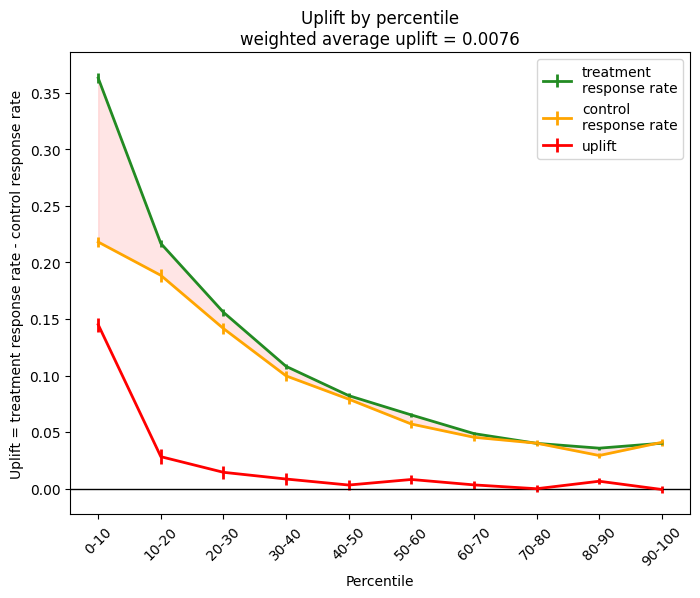

In [26]:
from sklift.viz import plot_uplift_by_percentile

# line plot
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='line');

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


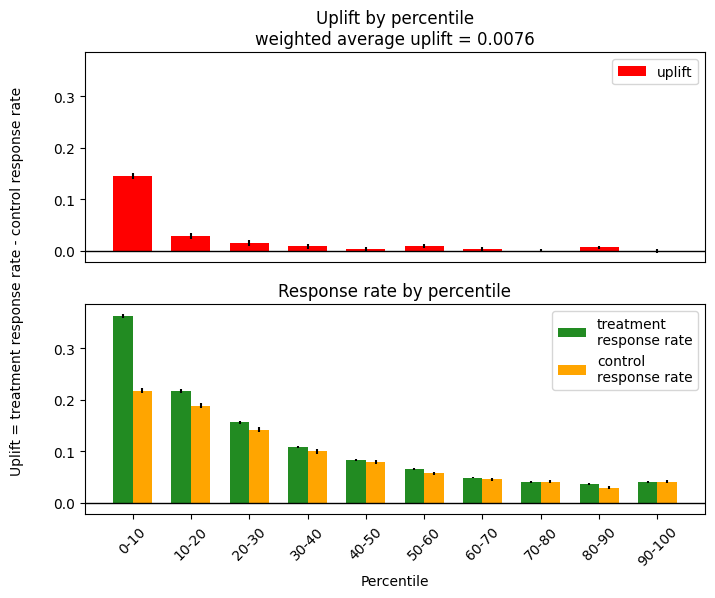

In [27]:
# bar plot
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='bar');

##   `Qini curve`

The curve plots the absolute incremental outcome of the treated group compared to group with no treatment.


plot Qini curve:
- `blue line` is a `real Qini curve` based on data.
- `red line` is an `ideal Qini curve` based on data. Code: `perfect=True`
- `grey line` is a `random Qini curve` based on data
    

##  `AUQC` (`area under Qini curve` or `Qini coefficient`)

`Qini coefficient` = `light blue area between the real Qini curve and the random Qini curve normalized on area between the random and the ideal line`

<img src="https://habrastorage.org/getpro/habr/upload_files/18a/f90/b30/18af90b30dbdff84e1b3a8ab77195101.png" width="400" alt="qini_curve">


- metric is printed at the title of the Qini curve plot
- can be called as a separate function

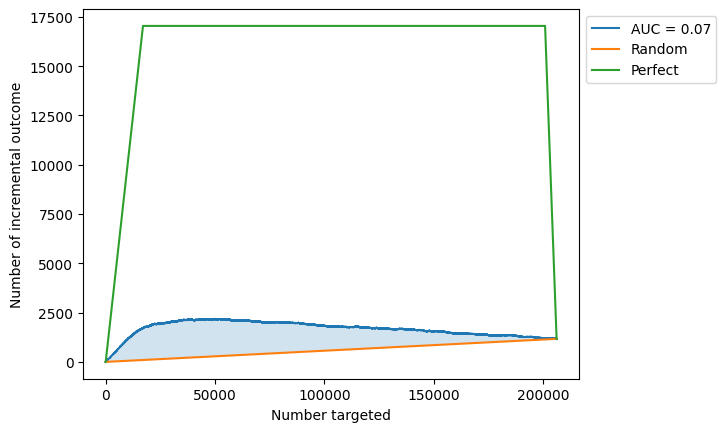

In [28]:
from sklift.viz import plot_qini_curve

# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_val, uplift_ct, trmnt_val, perfect=True);

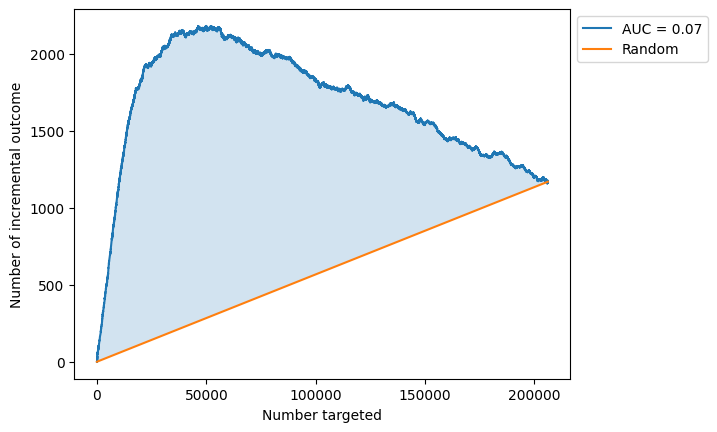

In [29]:
# no ideal Qini curve
# only real Qini curve
# perfect=False
plot_qini_curve(y_val, uplift_ct, trmnt_val, perfect=False);

In [30]:
from sklift.metrics import qini_auc_score

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_val, uplift_ct, trmnt_val)
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0702


##  `Uplift curve`

The Uplift curve plots incremental uplift.


   - `blue line` is a `real Uplift curve` based on data.
   - `red line` is an `ideal Uplift curve` based on data. Code: `perfect=True`
   - `grey line` is a `random Uplift curve` based on data.
    

##  `AUUQ` (`area under uplift curve`)

- `Area under uplift curve` = blue area between the real Uplift curve and the random Uplift curve
    - appears at the title of the Uplift curve plot
    - can be called as a separate function


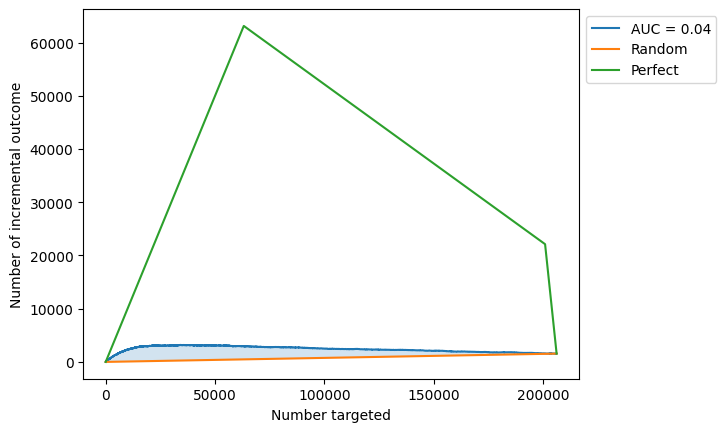

In [31]:
from sklift.viz import plot_uplift_curve

# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_ct, trmnt_val, perfect=True);

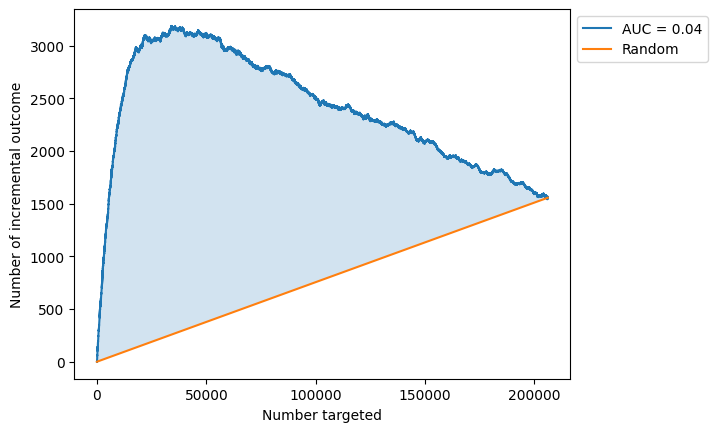

In [32]:
# only real
# perfect=False
plot_uplift_curve(y_val, uplift_ct, trmnt_val, perfect=False);

In [33]:
from sklift.metrics import uplift_auc_score

# AUUQ = area under uplift curve
auuc = uplift_auc_score(y_val, uplift_ct, trmnt_val)
print(f"Uplift auc score on full data: {auuc:.4f}")

Uplift auc score on full data: 0.0427
